In [1]:
!pip install transformers

import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

pd.set_option('display.max_colwidth', None)
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'# This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2.
BATCH_SIZE = 16
N_EPOCHS = 3

     |████████████████████████████████| 2.8 MB 10.4 MB/s 
     |████████████████████████████████| 636 kB 61.9 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 895 kB 53.8 MB/s 
     |████████████████████████████████| 3.3 MB 60.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
df = pd.read_csv('/content/Question - Sheet1.csv')
df.head()

,Question,Class
0,In which decade was the American Institute of Electrical Engineers (AIEE) founded?,Sc
1,What is part of a database that holds only one type of information?,Sc
2,OS' computer abbreviation usually means ?,Sc
3,In which decade with the first transatlantic radio broadcast occur?,Sc
4,.MOV' extension refers usually to what kind of file?,Sc


In [6]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

In [7]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
stop_words = set(stopwords.words("english"))
stop_words.add('rt')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()
giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|' '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'

def clean_text(text):
    text = re.sub('"', "", text)
    text = re.sub(mention_regex, ' ',text) #removing all user names
    text = re.sub(giant_url_regex, ' ', text)  #remocing the urls
    text = text.lower()
    text = re.sub("hm+", "", text) #removing variants of hmmm
    text = re.sub("[^a-z]+", " ", text) #removing all numbers, special chars like @,#,? etc
    text = text.split()
    text = [word for word in text if not word in stop_words]
    #text = [d[word] if word in d else word for word in text]  #replacing some slangs
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

In [9]:
df['processed_tweets'] = df.Question.apply(lambda x: clean_text(x))   # df.review.map(clean_text) Also can be used
df.head()

,Question,Class,label,processed_tweets
0,In which decade was the American Institute of Electrical Engineers (AIEE) founded?,Sc,1,decade american institute electrical engineer aiee found
1,What is part of a database that holds only one type of information?,Sc,1,part database hold one type information
2,OS' computer abbreviation usually means ?,Sc,1,o computer abbreviation usually mean
3,In which decade with the first transatlantic radio broadcast occur?,Sc,1,decade first transatlantic radio broadcast occur
4,.MOV' extension refers usually to what kind of file?,Sc,1,mov extension refer usually kind file


In [3]:
def ratio(x):
  if x=='Sc':
    return 1
  else:
    return 0;

In [10]:
df['label'] = df['Class'].apply(ratio)
df

,Question,Class,label,processed_tweets
0,In which decade was the American Institute of Electrical Engineers (AIEE) founded?,Sc,1,decade american institute electrical engineer aiee found
1,What is part of a database that holds only one type of information?,Sc,1,part database hold one type information
2,OS' computer abbreviation usually means ?,Sc,1,o computer abbreviation usually mean
3,In which decade with the first transatlantic radio broadcast occur?,Sc,1,decade first transatlantic radio broadcast occur
4,.MOV' extension refers usually to what kind of file?,Sc,1,mov extension refer usually kind file
...,...,...,...,...
126,Which of the following ancient Tamil Kingdoms came to be known from Sangam Literature?,Ht,0,follow ancient tamil kingdom come know sangam literature
127,Which of the following book is the sequel of an epic ‘Silappadikarma’?,Ht,0,follow book sequel epic silappadikarma
128,Which of the following is the equivalent term used for Raja in early vedic era?,Ht,0,follow equivalent term use raja early vedic era
129,Who among the following was contemporary of Pushyamitra Sunga?,Ht,0,among follow contemporary pushyamitra sunga


In [11]:
x = df['processed_tweets']
y = df['label']
print(x.shape)
print(y.shape)

(131,)
(131,)


In [12]:
from sklearn.model_selection import train_test_split as tts

In [13]:

X_train,X_test,y_train,y_test = tts(x,y,test_size = 0.2)

In [14]:
pd.DataFrame(X_train)[:3]

,processed_tweets
59,bhimbethka madhya pradesh ancient indian site art prehistoric age find preserve rockshelters art belong
64,pillar edict asoka longest pillar
14,vvvf stand


In [15]:
X_train.shape, X_test.shape, y_train.shape

((104,), (27,), (104,))

In [16]:
print('The proportion in y_train\n',y_train.value_counts(normalize=True).mul(100))
print('The proportion in y_test\n',y_test.value_counts(normalize=True).mul(100))

The proportion in y_train
 0    72.115385
1    27.884615
Name: label, dtype: float64
The proportion in y_test
 0    59.259259
1    40.740741
Name: label, dtype: float64


In [17]:
MAX_LEN = X_train.apply(lambda s: len([x for x in s.split()])).max()
MAX_LEN

16

In [18]:
#define a tokenizer object
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

#tokenize the text (padding to max sequence in batch)
train_encodings = tokenizer(list(X_train.values), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test.values), truncation=True, padding=True)

#print the first paragraph and it transformation
print(f'First paragraph: \'{X_train[:1]}\'')
print(f'Input ids: {train_encodings["input_ids"][0]}')
print(f'Attention mask: {train_encodings["attention_mask"][0]}')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

First paragraph: '59    bhimbethka madhya pradesh ancient indian site art prehistoric age find preserve rockshelters art belong
Name: processed_tweets, dtype: object'
Input ids: [101, 1038, 14341, 20915, 2232, 2912, 20841, 7970, 3418, 2796, 2609, 2396, 14491, 2287, 2424, 7969, 5749, 16001, 7747, 2396, 7141, 102, 0, 0, 0, 0]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7201c7890>,
      dtype=object)

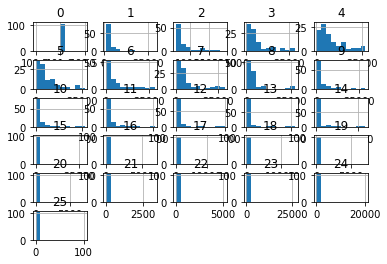

In [19]:
pd.DataFrame(train_encodings["input_ids"]).hist(bins = 10)

In [20]:
len(train_encodings["attention_mask"][0])

26

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    list(y_train.values)))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                    list(y_test.values)))

In [22]:
train_dataset

<TensorSliceDataset shapes: ({input_ids: (26,), attention_mask: (26,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [23]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions. 
model.compile(optimizer=optimizerr,                                     
              loss=losss,
              metrics=['accuracy'])

model.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE), 
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [24]:
model.evaluate(test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

2/2 [==============================] - 3s 354ms/step - loss: 0.2852 - accuracy: 0.8519


{'accuracy': 0.8518518805503845, 'loss': 0.2851894199848175}